In [1]:
import numpy as np
import pandas as pd
from numpy import *
from scipy.optimize import *
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FuncFormatter
from SALib.sample import saltelli
from SALib.analyze import sobol
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# internal functions

In [2]:
### don't make changes to the equations below

# 0.
# 1.
# 2.
# 3.
# 4.
# 5.
# 6.
# 7.

# 8. Air density, kg/m^3
def air_density(P_atm,T_air):
    density = 1.293*(P_atm/101325)*(273.15/(273.15+T_air))
    return density

# 9. Fan power, kW
def Fan_Power(mass_flow_rate,air_density,Fan_Pressure,Fan_e):
    power = mass_flow_rate/air_density*Fan_Pressure/Fan_e/1000
    return power

# 10. Pump power, kW
def Pump_Power(mass_flow_rate,Pump_Pressure,Pump_e,liquid_density):
    power = Pump_Pressure*mass_flow_rate/(1000*Pump_e*liquid_density)
    return power

# 11. Latent heat of vaporization of water: H_water, kj/kg
def Latent_heat_vaporization(T_water):
    H_water = -0.0013*(T_water)**(2)-2.3097*(T_water)+2500.5
    return H_water

# 12. In waterside economizer, the calculation of supply facility water temperature: T_sfw, (chiller system can also use this one if want)
def T_supplywater(T_sa,T_ra,HTE):
    T_sfw = T_ra - (T_ra - T_sa)/HTE
    return T_sfw

# 13. Usage scenario of waterside economizer: 1--use, 0--not use
def Waterside_economizer_use(T_rfw,T_wb_oa,AT_CT,AT_HE):
    if T_wb_oa + AT_CT + AT_HE <= T_rfw:
        use = 1
    else:
        use = 0
    return use

# 14. The heat removed by waterside economizer: WE_heat_removed, kW
def Water_heat_removed(Cooling_required,T_sfw,T_rfw,T_wb_oa,AT_CT,AT_HE):
    if (T_wb_oa + AT_CT + AT_HE) <= T_sfw:
        WE_heat_removed = Cooling_required
    elif (T_wb_oa + AT_CT + AT_HE) > T_sfw and (T_wb_oa + AT_CT + AT_HE) < T_rfw:
        WE_heat_removed = Cooling_required*((T_rfw-(T_wb_oa + AT_CT + AT_HE))/(T_rfw-T_sfw))
    else:
        WE_heat_removed = 0
    return WE_heat_removed

# 15.

# 16. Air or liquid cooling requirements
def Cooling_Requirement(Power_IT,UPS_e,PD_lr,L_percentage):
    Powerloss_UPS = Power_IT/UPS_e - Power_IT
    Powerloss_PD = Power_IT/(1-PD_lr) - Power_IT
    Power_Lighting = Power_IT * L_percentage
    Heat_people = 0
    # Total heat generaton of data center:
    DC_heat = Power_IT + Powerloss_UPS + Powerloss_PD + Power_Lighting + Heat_people
    # Cooling supplied by air: DC_heat_AC, kW (use air to cool IT devices)
    DC_heat_AC = DC_heat * AC_percentage
    # Cooling supplied by air: DC_heat_LC, kW (use liquid to cool IT devices)
    DC_heat_LC = DC_heat * LC_percentage
    return Powerloss_UPS,Powerloss_PD,Power_Lighting,Heat_people,DC_heat_AC,DC_heat_LC,DC_heat

# COP of Chiller, kW/kW (regression)
def COP_Chiller(load, t):
    COP = 16.798751 +  0.008840*t**2 - 8.528931*load**2 + 9.885294*load - 0.760621*t + 0.084615*load*t
    return COP

# Power used by IT equipments:
Power_IT = 1
# Percentage of air cooling:
AC_percentage = 100/100
# Percentage of liquid cooling:
LC_percentage = 1 - AC_percentage

In [3]:
def PUE_WUE_WES_Chiller(w_wech):
    T_sea = w_wech[0]
    P_atm = w_wech[1]
 
    UPS_e = w_wech[2] 
    PD_lr = w_wech[3]
    L_percentage = w_wech[4]
    
    T_sa_setpoint = w_wech[5]
    
    delta_T_air = w_wech[6]
    delta_T_water = w_wech[7]
    delta_T_sea = w_wech[8]
    
    Fan_Pressure_CRAC = w_wech[9]
    Fan_e_CRAC = w_wech[10]
    
    Pump_Pressure_HD = w_wech[11]
    Pump_e_HD = w_wech[12]
    Pump_Pressure_WE = w_wech[13]
    Pump_e_WE = w_wech[14]
    Pump_Pressure_CW = w_wech[15]
    Pump_e_CW = w_wech[16]
    Pump_Pressure_sea = w_wech[17]
    Pump_e_sea = w_wech[18]
    
    AT_HE = w_wech[19]
    HTE = w_wech[20]
    SHR = w_wech[21]
    Chiller_load = w_wech[22]
    pCOP = w_wech[23]
    
    #Cooling requirements: kW
    DC_heat_AC = Cooling_Requirement(Power_IT,UPS_e,PD_lr,L_percentage)[4]
    #CRAC supply air drybulb temperature: T_sa, C
    T_sa = T_sa_setpoint
    #CRAC return air drybulb temperature: T_sa, C
    T_ra = T_sa + delta_T_air
    #Density of supply air: density_sa, kg/m^3
    density_sa = air_density(P_atm,T_sa)
    #Mass flow rate of supply air: m_sa, kg/s
    m_sa = DC_heat_AC/(1.01 * delta_T_air )
    ###(1.Power)###: CRAC Fan power use: Power_Fan_CRAC, kW
    Power_Fan_CRAC = Fan_Power(m_sa,density_sa,Fan_Pressure_CRAC,Fan_e_CRAC)
    #Latent heat removed by air, DC_heat_latent, kW
    DC_heat_latent = Cooling_Requirement(Power_IT,UPS_e,PD_lr,L_percentage)[6]/SHR - DC_heat_AC
    #Cooling required: Cooling_required, kW
    Cooling_required = Cooling_Requirement(Power_IT,UPS_e,PD_lr,L_percentage)[6] + DC_heat_latent
    #Supply facility water temperature: T_sfw, C
    T_sfw = T_supplywater(T_sa,T_ra,HTE)
    #Return facility water temperature: T_rfw, C
    T_rfw = T_sfw + delta_T_water
    #Estimated temperature of condensate water: T_cw, C
    T_cw = (T_sfw + T_rfw)/2
    #Humidification amount, kg/s
    hd_amount = DC_heat_latent/Latent_heat_vaporization(T_cw)
    ###(2.Power)###: Power used by humidification pump, kW
    Power_Pump_hd = Pump_Power(hd_amount,Pump_Pressure_HD,Pump_e_HD,1000)
    #Usage scenario of waterside economizer: 1--use, 0--not use
    WE_use = Waterside_economizer_use(T_rfw,T_sea,0,AT_HE)
    #The heat removed by waterside economizer: WE_heat_removed, kW
    WE_heat_removed = Water_heat_removed(Cooling_required,T_sfw,T_rfw,T_sea,0,AT_HE)
    #Mass flow rate of facility water: m_sfw = m_rfw, kg/s
    m_sfw = WE_heat_removed/(4.2*delta_T_water)
    ###(3.Power)###: Power used by waterside economizer pump: Power_Pump_WE, kW
    Power_Pump_WE = Pump_Power(m_sfw,Pump_Pressure_WE,Pump_e_WE,1000)
    #Additional cooling needed, if the case, kW
    Chiller_heat_removed = Cooling_required - WE_heat_removed
    #COP of chiller: COP_chiller, kW/kW (regression Mean*(1+%COP))
    COP_chiller = COP_Chiller(Chiller_load,T_sea+0)*(1+pCOP)
    ###(4.Power)###: Power used by Chiller: Power_Chiller, kW
    Power_Chiller = Chiller_heat_removed/COP_chiller
    #Mass flow rate of chiller water: m_sw = m_rw, kg/s
    m_sw = Chiller_heat_removed/(4.2*(delta_T_water))
    ###(5.Power)###: Power used by chilled water pump: Power_Pump_CW, kW
    Power_Pump_CW = Pump_Power(m_sw,Pump_Pressure_CW,Pump_e_CW,1000)
    #Heat removed by sea water: CT_heat_removed, kW
    SEA_heat_removed = Cooling_required + Power_Chiller
    # Mass flow rate of sea water: m_CT, kg/s
    m_sea = SEA_heat_removed/(4.2*delta_T_sea) 
    ###(6.Power)###: Power used by seawater pump
    Power_Pump_sea = Pump_Power(m_sea,Pump_Pressure_sea,Pump_e_sea,1000)
    
    ###(0.Power)###: UPS
    Powerloss_UPS = Cooling_Requirement(Power_IT,UPS_e,PD_lr,L_percentage)[0]
    ###(0.Power)###: PD
    Powerloss_PD = Cooling_Requirement(Power_IT,UPS_e,PD_lr,L_percentage)[1]
    ###(0.Power)###: Lighting
    Power_Lighting = Cooling_Requirement(Power_IT,UPS_e,PD_lr,L_percentage)[2]
    
    PUE_WE_CH = (Power_IT + Powerloss_UPS + Powerloss_PD + Power_Lighting + Power_Fan_CRAC + Power_Pump_hd + Power_Pump_WE + Power_Chiller + Power_Pump_CW + Power_Pump_sea)/Power_IT
    return PUE_WE_CH

In [4]:
# Define the model inputs
problem_WES_Chiller = {
    'num_vars': 24,
    'names': ['T_sea','P_atm','UPS_e','PD_lr','L_percentage','T_sa_setpoint','delta_T_air',
              'delta_T_water','delta_T_sea','Fan_Pressure_CRAC','Fan_e_CRAC','Pump_Pressure_HD',
              'Pump_e_HD','Pump_Pressure_WE','Pump_e_WE','Pump_Pressure_CW','Pump_e_CW',
              'Pump_Pressure_sea','Pump_e_sea','AT_HE','HTE','SHR','Chiller_load','pCOP'
             ],
    'bounds': [[-2, 36], #T_sea
               [101325*0.9,101325*1.1], #P_atm
               [90/100, 99/100], #UPS_e
               [0/100, 2/100], #PD_lr
               [0/100, 0.2/100], #L_percentage
               [27,35],#T_sa_setpoint
               [25*5/9, 35*5/9], #delta_T_air
               [5, 10], #delta_T_water
               [5, 10], #delta_T_sea
               [400, 600], #Fan_Pressure_CRAC
               [0.65, 0.90], #Fan_e_CRAC
               [7000000*0.9, 7000000*1.1], #Pump_Pressure_HD
               [0.6, 0.8], #Pump_e_HD
               [143658*0.8,143658*1.2], #Pump_Pressure_WE
               [0.6, 0.8], #Pump_e_WE
               [143658*0.8,143658*1.2], #Pump_Pressure_CW
               [0.6, 0.8], #Pump_e_CW
               [30*9.8*1000,150*9.8*1000], #Pump_Pressure_sea
               [0.6,0.8], #Pump_e_sea
               [1.7,2.8], #AT_HE
               [0.7,0.9], #HTE
               [0.95,0.99], #SHR
               [0.2,0.8], #Chiller_load
               [-11/100,11/100], #pCOP
              ],             
    'dists': ['unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif','unif']
}

In [5]:
# Generate samples
sample_size = 10000
sobol_values = saltelli.sample(problem_WES_Chiller, sample_size)

Y_sobol = np.zeros([sobol_values.shape[0]])

for i, X in enumerate(sobol_values):
    Y_sobol[i] = PUE_WUE_WES_Chiller(X)

In [6]:
# Perform analysis
Si = sobol.analyze(problem_WES_Chiller, Y_sobol, num_resamples=100,print_to_console=False)

In [7]:
inx = np.where([Si['ST'] > 0.01])[1]
flabel = []

for i in inx:
    flabel.append(problem_WES_Chiller['names'][i])

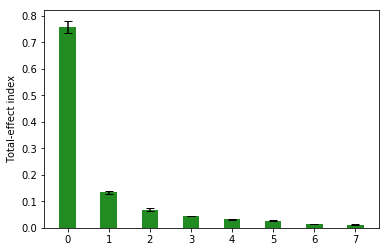

In [8]:
list = Si['ST'][Si['ST'] > 0.01]
index=np.argsort(list)[::-1]

list_cf = Si['ST_conf'][Si['ST'] > 0.01]

plt.bar(range(len(list)),list[index],width=0.4,yerr=list_cf[index],align='center',capsize=4,color='forestgreen')
plt.ylabel("Total-effect index")


plt.show()

In [9]:
print(flabel)
print(list)

['T_sea', 'UPS_e', 'T_sa_setpoint', 'delta_T_water', 'delta_T_sea', 'Pump_Pressure_sea', 'HTE', 'Chiller_load']
[0.75888282 0.13332835 0.06828062 0.01159874 0.01346274 0.04442289
 0.03186366 0.02640062]


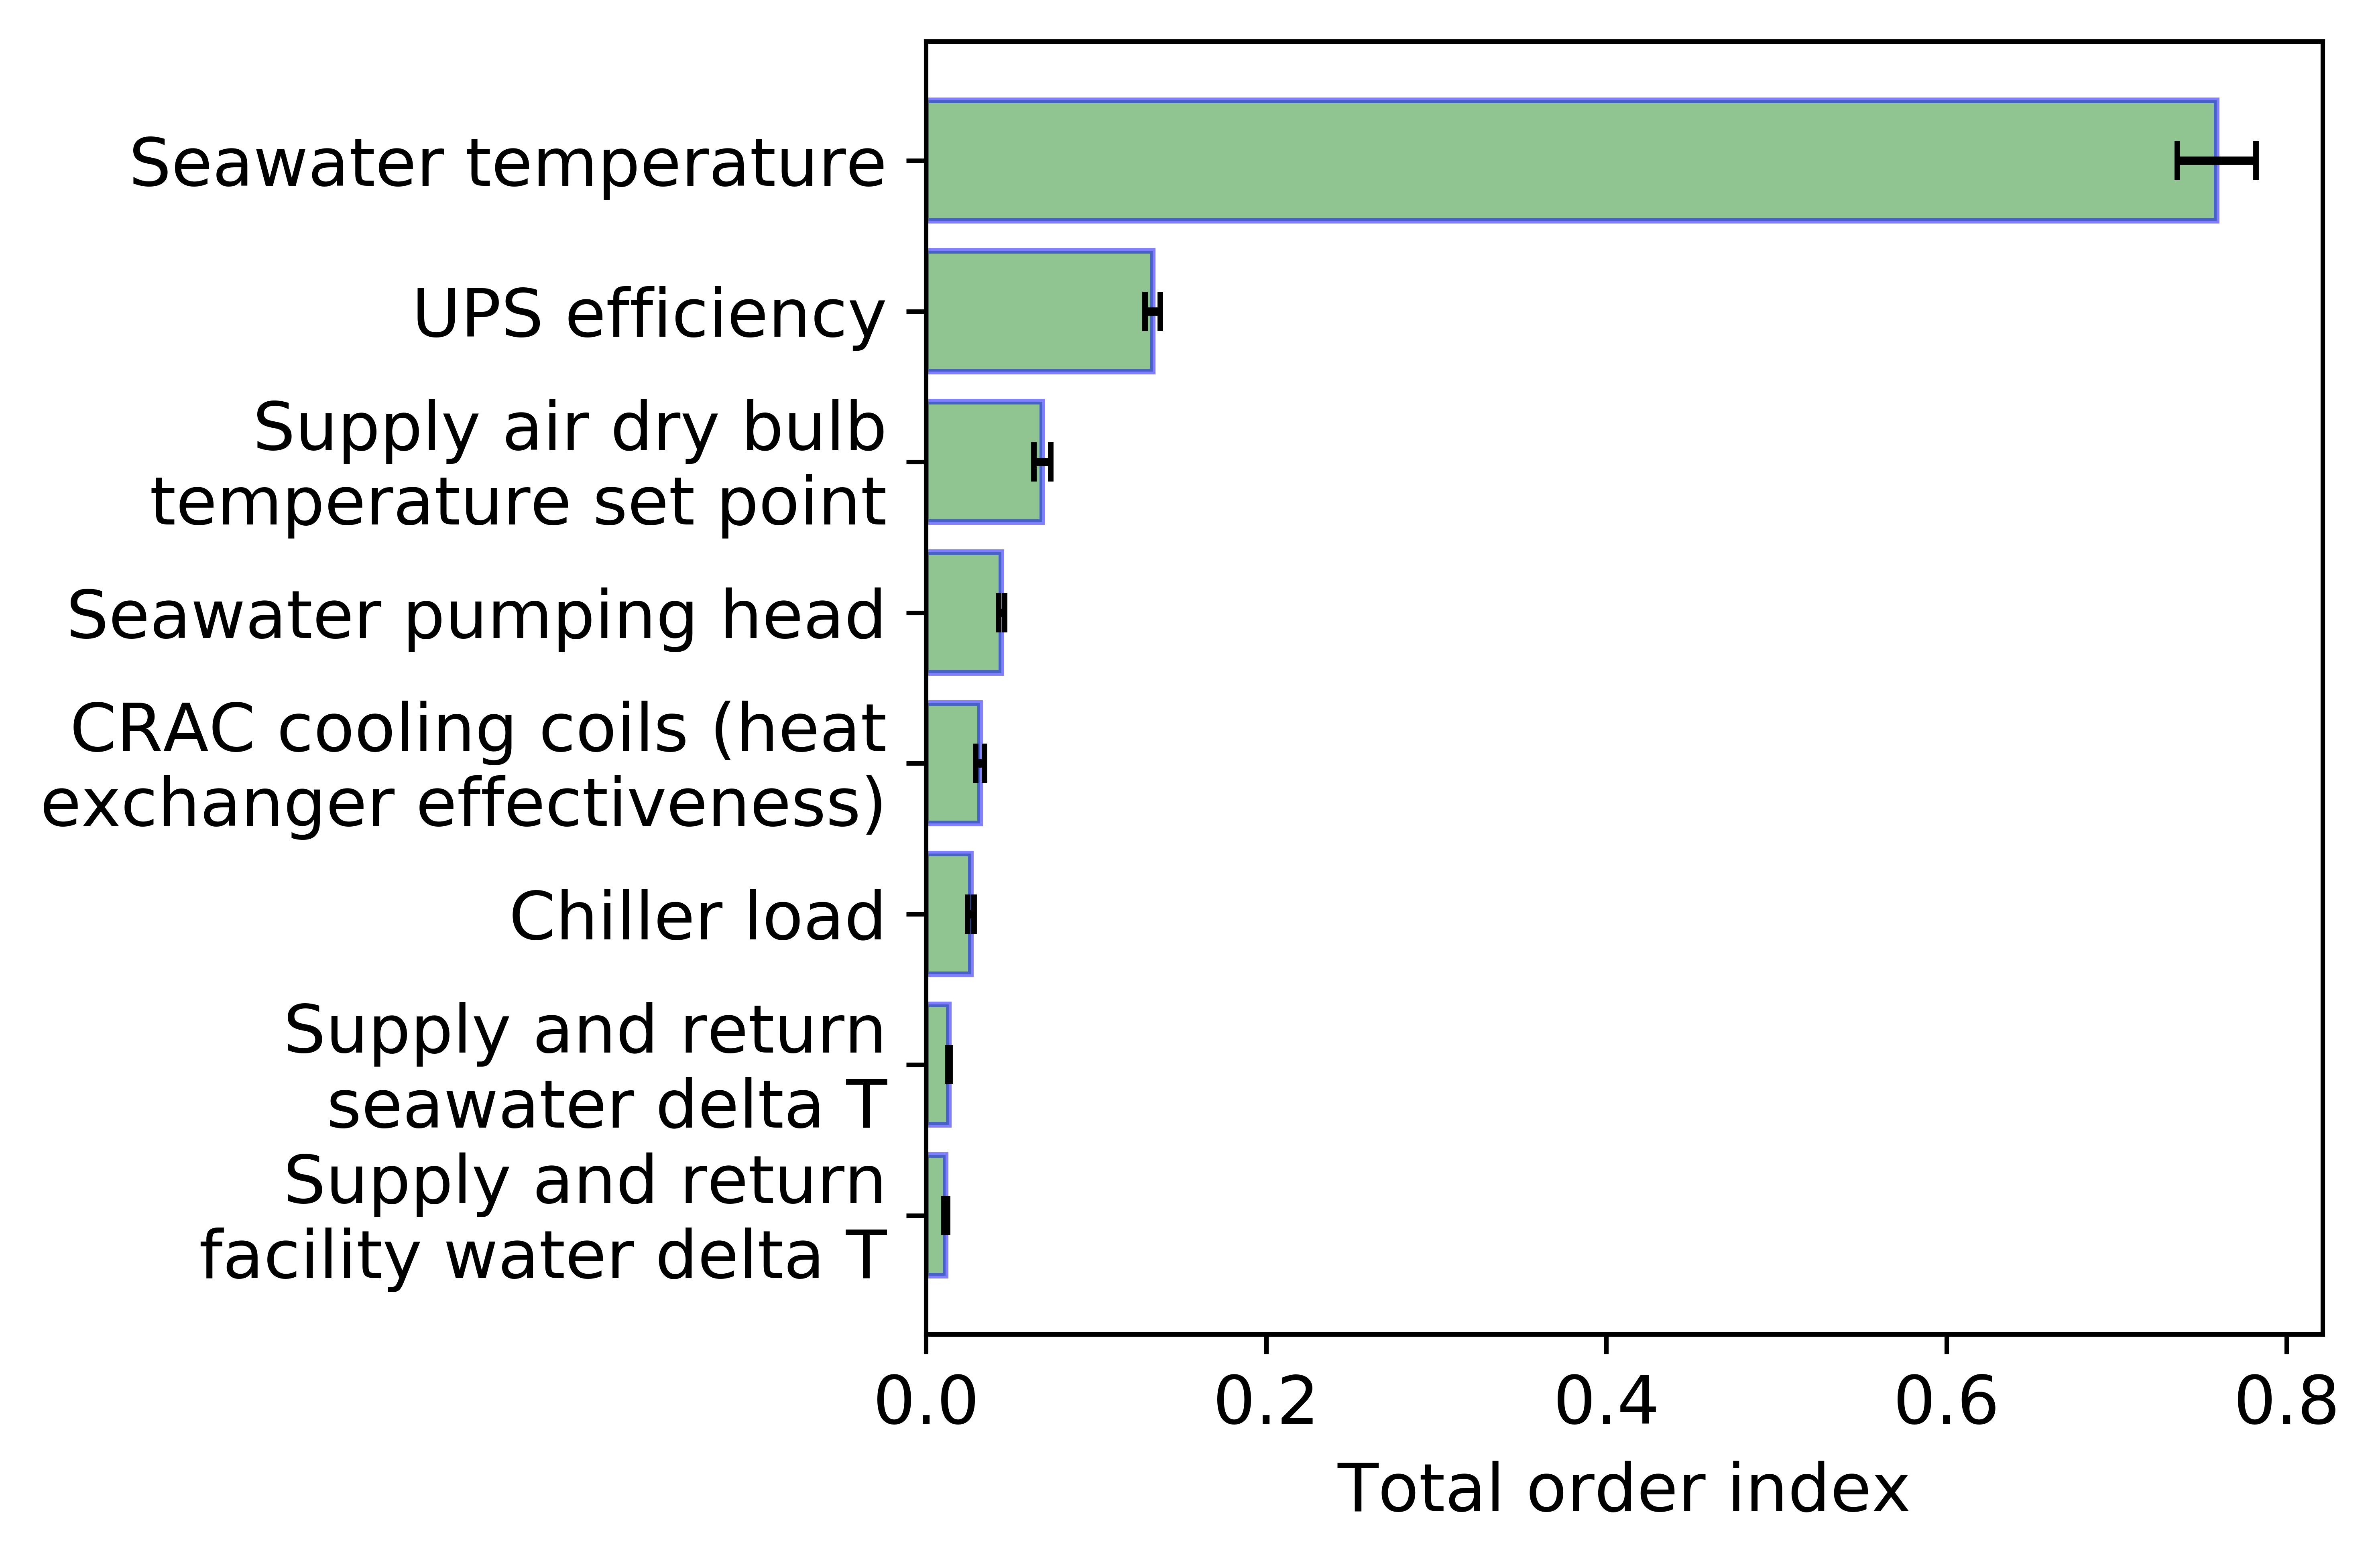

In [10]:
label = ['Seawater temperature','UPS efficiency','Supply air dry bulb\ntemperature set point','Seawater pumping head','CRAC cooling coils (heat\nexchanger effectiveness)','Chiller load','Supply and return\nseawater delta T','Supply and return\nfacility water delta T']
index=np.argsort(list)

plt.figure(dpi=1000)
plt.barh(range(len(list)), list[index], xerr=list_cf[index], align='center',height=0.8,capsize=3.5,color='forestgreen',alpha=0.5,edgecolor='blue')
plt.xlabel("Total order index",fontsize=12)
plt.yticks(range(len(list)),label[::-1], ha='right',fontsize=12)
plt.xticks(fontsize=12)
plt.rc('font',family='Calibri')

plt.tight_layout()
#plt.savefig("SEA_sensitity.svg", dpi=1000)
plt.show()

In [11]:
inx = np.argsort(Si['S1'])[::-1]
flabel_2 = []

for i in inx:
    flabel_2.append(problem_WES_Chiller['names'][i])
    
inx_1 = np.argsort(Si['ST'])[::-1]
flabel_1 = []

for i in inx_1:
    flabel_1.append(problem_WES_Chiller['names'][i])

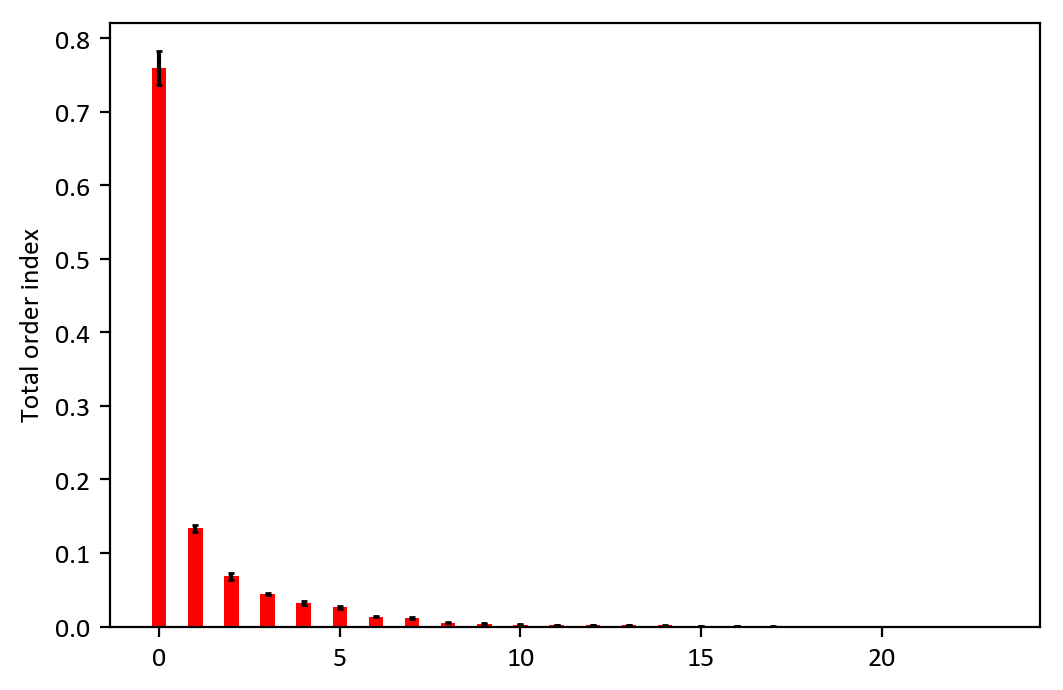

In [12]:
plt.figure(dpi=200)
list_2 = Si['S1'][inx]
list_cf_2 = Si['S1_conf'][inx]

list_1 = Si['ST'][inx_1]
list_cf_1 = Si['ST_conf'][inx_1]

plt.bar(range(len(list_1)),list_1,width=0.4,yerr=list_cf_1,align='center',capsize=1,color='r')

plt.ylabel("Total order index")

plt.show()

In [13]:
print(flabel_1)
print(list_1) 

['T_sea', 'UPS_e', 'T_sa_setpoint', 'Pump_Pressure_sea', 'HTE', 'Chiller_load', 'delta_T_sea', 'delta_T_water', 'PD_lr', 'pCOP', 'delta_T_air', 'Pump_e_sea', 'Fan_Pressure_CRAC', 'AT_HE', 'Fan_e_CRAC', 'P_atm', 'SHR', 'Pump_Pressure_WE', 'L_percentage', 'Pump_e_WE', 'Pump_Pressure_CW', 'Pump_e_CW', 'Pump_e_HD', 'Pump_Pressure_HD']
[7.58882818e-01 1.33328354e-01 6.82806226e-02 4.44228908e-02
 3.18636614e-02 2.64006183e-02 1.34627392e-02 1.15987374e-02
 5.45681499e-03 4.10976712e-03 2.70443053e-03 2.36274324e-03
 2.19567949e-03 1.59442306e-03 1.46849107e-03 5.59371202e-04
 3.01928135e-04 7.38877390e-05 5.23535492e-05 3.88559603e-05
 1.79591636e-05 9.88066552e-06 1.88741974e-08 9.12478798e-09]


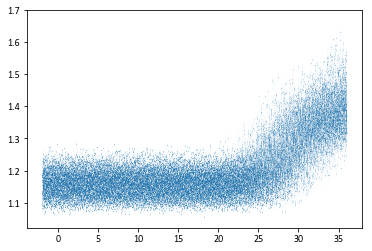

In [14]:
plt.scatter(sobol_values[:,0],Y_sobol,s=0.0001)